In [1]:
"""
jupyter-nbconvert report_correlations.ipynb --to python; python -u report_correlations.py

MDIRS=$(ls -d trained_models/ExptDynamic20210521/*VRNN*/)
for MDIR in $MDIRS; do
  python -u report_correlations.py --model_dir $MDIR
done
"""

'\njupyter-nbconvert report_correlations.ipynb --to python; python -u report_correlations.py\n\nMDIRS=$(ls -d trained_models/ExptDynamic20210521/*VRNN*/)\nfor MDIR in $MDIRS; do\n  python -u report_correlations.py --model_dir $MDIR\ndone\n'

In [2]:
from __future__ import division
import os
import glob
import pickle
from natsort import natsorted
import argparse
import os
import sys
import numpy as np
import tqdm
import pandas as pd

import numpy as np
from pprint import pprint
import glob
import sys
sys.path.append('../')
from plume_env import PlumeEnvironment, PlumeFrameStackEnvironment
import config
import agents
import agent_analysis
import os
import sklearn
import sklearn.decomposition as skld

import importlib
import log_analysis
importlib.reload(log_analysis)
import torch

import config
np.random.seed(config.seed_global)

In [3]:
import sys
batchmode = False
if 'ipykernel_launcher' in sys.argv[0]:
    print("Interactive mode")
else:
    batchmode = True
    print("Batch/CLI mode")
    import argparse

Interactive mode


In [4]:
# Common
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style="white")
# print(plt.style.available)

mpl.rcParams['figure.dpi'] = 100
dpi_save = 300
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

if batchmode:
    matplotlib.use("Agg")
else:
    # Interactive vs. CLI
    %matplotlib inline
    # %config InlineBackend.figure_format = 'svg'
    %config InlineBackend.figure_format = 'retina'


    

In [5]:
if batchmode:
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('--model_dir', default=None)
    args = parser.parse_args()
    print(args)
    
    model_dir = args.model_dir
else:
    model_dir = natsorted(glob.glob(f'/home/satsingh/plume/plumezoo/latest/fly/memory/*VRNN*/'))[3]
#     model_dir = '/home/satsingh/plume/plumezoo/20210506/fly_all/memory/plume_20210418_VRNN_constantx5b5noisy6x5b5_bx1.0_t1M_w3_stepoob_h64_wd0.01_codeVRNN_seed19507d3/'
    # model_dir = '/home/satsingh/plume/plumezoo/20210504/fly/memory/plume_20210418_VRNN_constantx5b5noisy6x5b5_bx1.0_t1M_w3_stepoob_h64_wd0.01_codeVRNN_seed19507d3/'
    # model_dir = '/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210507_VRNN_constantx5b5noisy3x5b5_stepoobstray_bx0.30.8_t5000004000000_q2.01.0_h64_wd0.01_n4_codeVRNN_seed2106602/'

outdir = f'{model_dir}/report_arch/'
os.makedirs(outdir, exist_ok=True)
print(outdir)

/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch/


In [6]:

model_seed = model_dir.split('seed')[-1].split('/')[0]
print("model_dir:", model_dir)
print("model_seed:", model_seed)



is_recurrent = True if ('GRU' in model_dir) or ('VRNN' in model_dir) else False

logfiles = natsorted(glob.glob(model_dir + '*.pkl'))
logfiles

model_dir: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377/
model_seed: 2760377


['/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377/constantx5b5.pkl',
 '/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377/constantx5b5_0.2.pkl',
 '/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377/constantx5b5_0.4.pkl',
 '/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377/constantx5b5_0.6.pkl',
 '/home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0

In [7]:
# def get_homed_df(model_dir, use_datasets):
#     episodes_df = []
#     for dataset in use_datasets:
#         log_fname = f'{model_dir}/{dataset}.pkl'
#         with open(log_fname, 'rb') as f_handle:
#             episode_logs = pickle.load(f_handle)

#         for idx in tqdm.tqdm( range(len(episode_logs)) ):
#             log = episode_logs[idx]
#             outcome = log['infos'][-1][0]['done']
#             if outcome == "HOME":
# #             if True:
#                 episodes_df.append({'dataset': dataset, 
#                                     'idx': idx,
#                                     'log': log,
#                                     'outcome': outcome,
#                                    })

#     episodes_df = pd.DataFrame(episodes_df)
#     return(episodes_df)

# use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
# # use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy6x5b5']

# if not batchmode:
# #     use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
#     use_datasets = ['noisy3x5b5']

# homed_df = get_homed_df(model_dir, use_datasets)
# print(homed_df.shape)
# homed_df.head()

In [8]:
use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
if not batchmode:
#     use_datasets = ['constantx5b5', 'switch45x5b5', 'noisy3x5b5']
    use_datasets = ['noisy3x5b5']

homed_df = log_analysis.get_selected_df(model_dir, 
                              use_datasets, 
                              n_episodes_home=60, 
                              n_episodes_other=60,
                              min_ep_steps=0)
print(homed_df.shape)
homed_df

(120, 5)


,dataset,idx,ep_length,log,outcome
0,noisy3x5b5,222,278,"{'trajectory': [[8.010399457246086, 3.46640463...",HOME
1,noisy3x5b5,228,277,"{'trajectory': [[7.988567042600009, 3.75857687...",HOME
2,noisy3x5b5,209,277,"{'trajectory': [[8.026033910134746, 4.07666357...",HOME
3,noisy3x5b5,239,276,"{'trajectory': [[8.041879169757301, 3.99839858...",HOME
4,noisy3x5b5,204,276,"{'trajectory': [[8.079235884198436, 4.04289877...",HOME
...,...,...,...,...,...
115,noisy3x5b5,141,135,"{'trajectory': [[6.010001417499316, 1.58354753...",OOB
116,noisy3x5b5,29,135,"{'trajectory': [[3.9595490583748165, 0.8441937...",OOB
117,noisy3x5b5,145,132,"{'trajectory': [[5.987189292931187, 1.31912242...",OOB
118,noisy3x5b5,130,131,"{'trajectory': [[6.012275894572262, 1.33059792...",OOB


In [9]:
N_HISTORY = 75
h_episodes = []
traj_dfs = []
squash_action = True
for idx, row  in tqdm.tqdm(homed_df.iterrows()):
    episode_log = row['log']
    ep_activity = log_analysis.get_activity(episode_log, is_recurrent, do_plot=False)
    h_episodes.append(ep_activity)

    traj_df = log_analysis.get_traj_df(episode_log, 
                                       extended_metadata=True, 
                                       squash_action=squash_action,
                                       n_history=N_HISTORY)
    traj_df['tidx'] = np.arange(traj_df.shape[0], dtype=int)
    for colname in ['dataset', 'idx', 'outcome']:
        traj_df[colname] = row[colname] 
    
    traj_dfs.append(traj_df)
    
h_episodes_stacked = np.vstack(h_episodes)
traj_df_stacked = pd.concat(traj_dfs)
print(h_episodes_stacked.shape, traj_df_stacked.shape)
traj_df_stacked['h'] = h_episodes_stacked.tolist()
print(h_episodes_stacked.shape, traj_df_stacked.shape)
traj_df_stacked.columns

120it [00:09, 12.34it/s]


(23488, 64) (23488, 151)
(23488, 64) (23488, 152)


Index(['loc_x', 'loc_y', 't_val', 'wind_theta_obs', 'wind_x_obs', 'wind_y_obs',
       'step', 'turn', 'odor_obs', 'stray_distance',
       ...
       'stray_distance_dt1', 'r_step_dt1', 'agent_angle_ground_dt1',
       'wind_angle_ground_dt1', 'wind_speed_ground_dt1', 'tidx', 'dataset',
       'idx', 'outcome', 'h'],
      dtype='object', length=152)

In [10]:
results = []
exclude_columns = ['regime', 'dataset', 'idx', 'outcome', 'tidx', 'h']
include_colums = [ x for x in traj_df_stacked.columns if x not in exclude_columns ] 
for colname in tqdm.tqdm(include_colums):
    y = traj_df_stacked[colname]
    X = h_episodes_stacked[ ~y.isna() ]
    y = y[ ~y.isna() ]
    
    reg = sklearn.linear_model.LinearRegression().fit(X, y)
    R2 = reg.score(X, y)
    results.append({
        'feature': colname,
        'R2': R2,
        'coef': reg.coef_,
        'intercept': reg.intercept_,
    })
    
results = pd.DataFrame(results)    
results = results.sort_values(by=['R2'], ascending=False)

100%|██████████| 146/146 [00:08<00:00, 17.36it/s]


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    if not batchmode:
        display(results.head(n=20))

,feature,R2,coef,intercept
95,odor_ma_6,0.967116,"[-0.044046298, 0.49426833, -0.008133478, -0.14...",0.063358
96,odor_ma_8,0.964224,"[-0.06538503, 0.36007285, 0.03277251, -0.05077...",0.094080
5,wind_y_obs,0.959579,"[0.3907183, 0.12927985, -0.56153524, 0.0247409...",-0.438633
94,odor_ma_4,0.955920,"[-0.1798948, 0.52619267, -0.1759536, -0.064219...",0.079164
97,odor_ma_10,0.955414,"[0.062762864, 0.25609598, 0.002498217, 0.03945...",0.156730
6,step,0.949636,"[0.29764566, -0.29567164, -0.12088736, 0.65903...",0.538754
59,odor_ewm_10,0.948486,"[0.025003035, 0.40855905, -0.055450477, -0.029...",0.139978
58,odor_ewm_8,0.948225,"[0.002469173, 0.43339685, -0.058871925, -3.146...",0.121465
60,odor_ewm_12,0.945046,"[0.04599265, 0.38856518, -0.05738437, -0.05096...",0.156760
98,odor_ma_12,0.944912,"[0.14393772, 0.2197435, -0.04846, 0.008974025,...",0.202681


6
Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//R2s_odor_ma_2760377.png


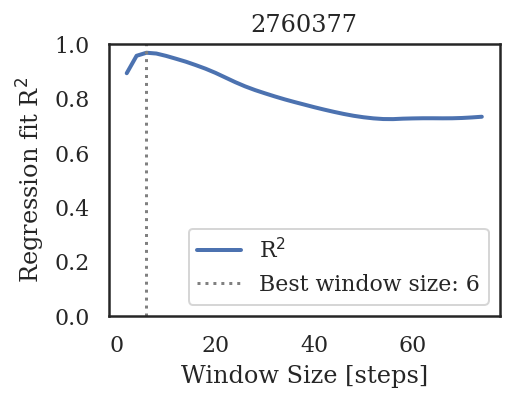

10
Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//R2s_odor_ewm_2760377.png


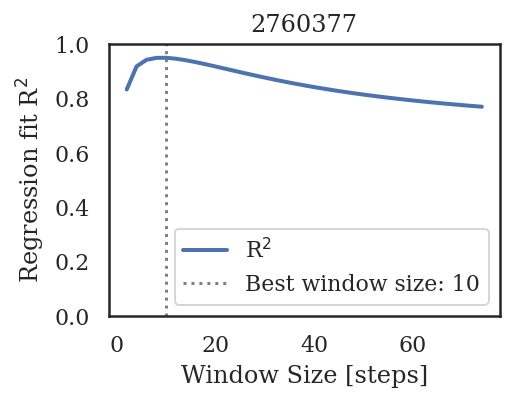

74
Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//R2s_odor_enc_2760377.png


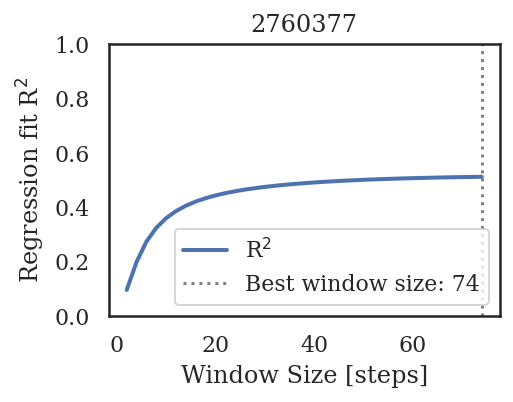

In [12]:
# Plot odor_ma

best_window_lengths = {}
best_window_r2s = {}
# for prefix in ['odor_ma_']:
for prefix in ['odor_ma_', 'odor_ewm_', 'odor_enc_']:
    fig = plt.figure(figsize=(3.5,2.5))
    rows = [prefix in x for x in results.feature]
    results_subset = results.loc[rows, :]
    window_sizes = [int(x.split(prefix)[-1]) for x in results_subset.feature]
#     plt.scatter(x=window_sizes, y=results_subset.R2, label=prefix[5:-1].upper())
    
    results_subset_df = pd.DataFrame({
        'window_size': window_sizes,
        'R2': results_subset.R2,
    }).sort_values(by='window_size')
#     plt.plot(window_sizes, results_subset.R2, label=prefix[5:-1].upper())
    plt.plot(results_subset_df['window_size'], 
             results_subset_df['R2'], 
             lw=2,
             label=f"R$^2$")
#              label=prefix[5:-1].upper() + f" R$^2$")

    plt.ylabel(f'Regression fit R$^2$')    
    plt.xlabel(f'Window Size [steps]')    

    
    best_window_size = results_subset_df['window_size'].iloc[ results_subset_df['R2'].argmax() ]
    best_window_r2 = results_subset_df['R2'].iloc[ results_subset_df['R2'].argmax() ]
    print(best_window_size)
    best_window_lengths[ prefix[:-1] ] =  best_window_size # add to dict
    best_window_r2s[ prefix[:-1] ] =  best_window_r2 # add to dict

    ax = plt.gca()
    ax.axvline(best_window_size, ls=':', c='grey', label=f'Best window size: {best_window_size}')

    # plt.yscale('log')
    plt.ylim(0.0,1.0)
    plt.legend(loc='lower right')

    if not batchmode:
        plt.title(model_seed)

    # fname = f"{model_dir}/R2s_odor_{model_seed}.png"
    fname = f"{outdir}/R2s_{prefix}{model_seed}.png"
    plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
    print("Saved:", fname)
    plt.show()


    

Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//R2s_common_2760377.png


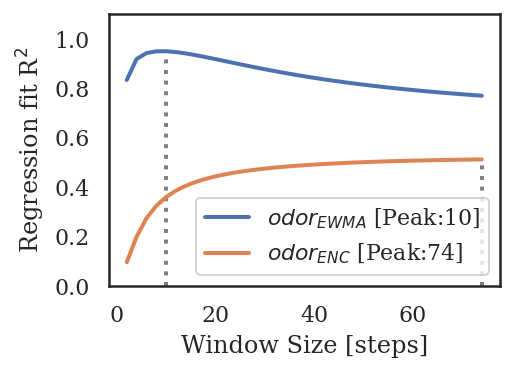

In [13]:
l_labels = {
    'odor_ewm': r'$odor_{EWMA}$',
    'odor_enc': r'$odor_{ENC}$',
}
# l_colors = {
#     'odor_ewm': 'tab:blue',
#     'odor_enc': 'tab:orange',
# }



fig = plt.figure(figsize=(3.5,2.5))
for prefix in ['odor_ewm_', 'odor_enc_']:
    rows = [prefix in x for x in results.feature]
    results_subset = results.loc[rows, :]
    window_sizes = [int(x.split(prefix)[-1]) for x in results_subset.feature]


    
    results_subset_df = pd.DataFrame({
        'window_size': window_sizes,
        'R2': results_subset.R2,
    }).sort_values(by='window_size')

    R2_argmax = results_subset_df['R2'].argmax()
    best_window_size = results_subset_df['window_size'].iloc[ R2_argmax ]


    plt.plot(results_subset_df['window_size'], 
             results_subset_df['R2'], 
             lw=2,
             label=l_labels[prefix[:-1]] + f" [Peak:{best_window_size}]")

    plt.ylabel(f'Regression fit R$^2$')    
    plt.xlabel(f'Window Size [steps]')    

    
    ax = plt.gca()
#     ax.axvline(best_window_size, ls=':', c='grey', label=f'Best window size: {best_window_size}')
    ax.vlines(best_window_size, 
              0, 
              results_subset_df['R2'].max(), 
              color='grey', 
#               color=l_colors[prefix[:-1]], 
              ls=':', lw=2)
    
    plt.ylim(0.0,1.1)
    plt.legend(loc='lower right')

#     if not batchmode:
#         plt.title(model_seed)

fname = f"{outdir}/R2s_common_{model_seed}.png"
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
print("Saved:", fname)
plt.show()



In [14]:
import json
# Hell: https://stackoverflow.com/questions/11942364/typeerror-integer-is-not-json-serializable-when-serializing-json-in-python
def convert(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError
    
json_fname = f"{outdir}/best_window_lengths_{model_seed}.json"
with open(json_fname, 'w') as fp:
    json.dump(best_window_lengths, fp,  indent=4, default=convert)    
print(best_window_lengths)

json_fname = f"{outdir}/best_window_r2s_{model_seed}.json"
with open(json_fname, 'w') as fp:
    json.dump(best_window_r2s, fp,  indent=4, default=convert)    
print(best_window_r2s)

{'odor_ma': 6, 'odor_ewm': 10, 'odor_enc': 74}
{'odor_ma': 0.967116010253039, 'odor_ewm': 0.9484856847266261, 'odor_enc': 0.5106809581918772}


In [15]:
# list(zip(window_sizes, results_subset.R2))

## How well do represented variables predict behavior


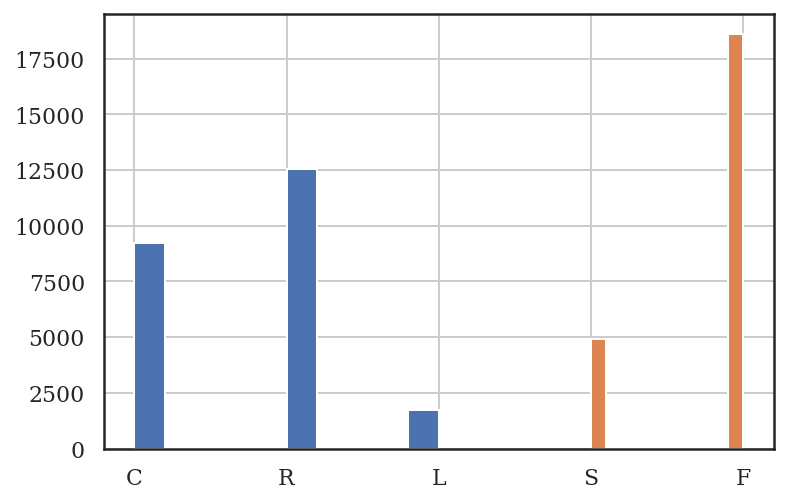

In [16]:
def discretize_turn3(t): # 3-level
    if t >= 0.75:
        return 'L'
    elif t <= 0.25:
        return 'R'
    else:
        return 'C'
    
# def discretize_turn5(t): # 5-level, any reason to make it harder?
#     if t >= 0.8:
#         return 'LL'
#     if t >= 0.6 and t < 0.8:
#         return 'L'
#     if t >= 0.2 and t < 0.4:
#         return 'R'
#     elif t <= 0.2:
#         return 'RR'
#     else:
#         return 'C'
    
# traj_df['turn'].apply(discretize_turn)
traj_df_stacked['turn_discrete'] = traj_df_stacked['turn'].apply(discretize_turn3)
traj_df_stacked['turn_discrete'].hist()

def discretize_step(s):
    if s >= 0.5:
        return 'F' # fast
    else:
        return 'S' # slow
traj_df_stacked['step_discrete'] = traj_df_stacked['step'].apply(discretize_step)
traj_df_stacked['step_discrete'].hist()

# Not used in this section -- used in the ring-discovery section
from sklearn.preprocessing import KBinsDiscretizer
def discretize_head(series):
    enc = KBinsDiscretizer(n_bins=16, encode='ordinal', strategy='uniform')
    X_binned = enc.fit_transform(series.to_numpy().reshape(-1, 1))
    (((np.unique(X_binned) + 1) % 16)/2).astype(int) # this transformation centers bin-0 around value-0
    X_binned = (((X_binned + 1) % 16)/2).astype(int) # this transformation centers bin-0 around value-0
    return X_binned

traj_df_stacked['head_discrete'] = discretize_head(traj_df_stacked['agent_angle_ground'])

x_columns = [
#     'wind_theta_obs', 
    'wind_x_obs', 
    'wind_y_obs',
    'odor_obs',
    'odor_lastenc',
    'agent_angle_ground',
#     f'odor_ma_{best_window_lengths["odor_ma"]}',
    f'odor_ewm_{best_window_lengths["odor_ewm"]}',
    f'odor_enc_{best_window_lengths["odor_enc"]}',

]
y_columns = ['turn_discrete', 'step_discrete']




traj_df_stacked['Y'] = traj_df_stacked['turn_discrete'] + traj_df_stacked['step_discrete']



# # Does not split by episode
# X = traj_df_stacked.loc[:, x_columns].fillna(0)
# Y = traj_df_stacked['Y'].fillna(0)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

# Split by dataset-outcome-episode_idx
traj_df_stacked.reset_index(drop=True, inplace=True) 
traj_df_train = traj_df_stacked.groupby(by=['dataset', 'outcome', 'idx']).sample(frac=0.8)
traj_df_test = traj_df_stacked.drop( index=traj_df_train.index )
X_train = traj_df_train.loc[:, x_columns].fillna(0)
X_test = traj_df_test.loc[:, x_columns].fillna(0)
y_train = traj_df_train['Y'].fillna(0)
y_test = traj_df_test['Y'].fillna(0)
# traj_df_train.head()
# traj_df_test.head()
# traj_df_train.shape, traj_df_test.shape, traj_df_stacked.shape
# traj_df_train.shape, traj_df_stacked.shape
# traj_df_train.index, traj_df_stacked.index

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform, randint

# Without HypOpt
# clf = RandomForestClassifier(n_estimators=30, n_jobs=8, oob_score=True, random_state=137)
# clf.fit(X_train, y_train)


HYPOPT_ITER = 10
HYPOPT_CV = 3
if batchmode:
    HYPOPT_ITER = 20
    HYPOPT_CV = 3
    
model = RandomForestClassifier(n_estimators=30, 
#                              class_weight="balanced",
                             n_jobs=8, 
                             oob_score=True, 
                             random_state=137)
param_distributions = {"n_estimators": randint(10, 50), }
#                "max_depth": randint(2, 10)}
rnd_search_cv = RandomizedSearchCV(model, param_distributions, 
                             n_iter=HYPOPT_ITER, verbose=2, 
                             cv=HYPOPT_CV, random_state=137)

rnd_search_cv.fit(X_train, y_train)
clf = rnd_search_cv.best_estimator_
best_params = rnd_search_cv.best_params_
print(f"{model_seed}: best_params_:{rnd_search_cv.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................................n_estimators=40; total time=   1.1s
[CV] END ....................................n_estimators=40; total time=   0.4s
[CV] END ....................................n_estimators=40; total time=   0.4s
[CV] END ....................................n_estimators=48; total time=   0.4s
[CV] END ....................................n_estimators=48; total time=   0.5s
[CV] END ....................................n_estimators=48; total time=   0.5s
[CV] END ....................................n_estimators=23; total time=   0.4s
[CV] END ....................................n_estimators=23; total time=   0.4s
[CV] END ....................................n_estimators=23; total time=   0.4s
[CV] END ....................................n_estimators=29; total time=   0.4s
[CV] END ....................................n_estimators=29; total time=   0.4s
[CV] END ....................................n_e

In [18]:
# clf_acc_train = clf.score(X_train, y_train)
clf_acc_train = clf.oob_score_ 
print("{}: Accuracy on train data: {:.2f}".format(model_seed, clf_acc_train))

clf_acc_test = clf.score(X_test, y_test)
print("{}: Accuracy on test data: {:.2f}".format(model_seed, clf_acc_test))

2760377: Accuracy on train data: 0.87
2760377: Accuracy on test data: 0.88


In [19]:
# Baseline 1
baseline_x_columns = [
    'wind_x_obs', 
    'wind_y_obs',
    'odor_obs',
]

X_train_baseline = X_train.loc[:,baseline_x_columns]
X_test_baseline = X_test.loc[:,baseline_x_columns]

# # Without HypOpt
# baseline_clf = RandomForestClassifier(n_estimators=30, n_jobs=8, seed=137)
# baseline_clf.fit(X_train_baseline, y_train)


rnd_search_cv.fit(X_train_baseline, y_train)
baseline_clf = rnd_search_cv.best_estimator_
best_params = rnd_search_cv.best_params_
print(f"{model_seed}: baseline_best_params_:{rnd_search_cv.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....................................n_estimators=40; total time=   0.5s
[CV] END ....................................n_estimators=40; total time=   0.5s
[CV] END ....................................n_estimators=40; total time=   0.4s
[CV] END ....................................n_estimators=48; total time=   0.4s
[CV] END ....................................n_estimators=48; total time=   0.4s
[CV] END ....................................n_estimators=48; total time=   0.5s
[CV] END ....................................n_estimators=23; total time=   0.3s
[CV] END ....................................n_estimators=23; total time=   0.3s
[CV] END ....................................n_estimators=23; total time=   0.3s
[CV] END ....................................n_estimators=29; total time=   0.4s
[CV] END ....................................n_estimators=29; total time=   0.4s
[CV] END ....................................n_e

In [20]:
baseline_clf

RandomForestClassifier(n_estimators=24, n_jobs=8, oob_score=True,
                       random_state=137)

In [21]:
# baseline_clf_acc_train = baseline_clf.score(X_train_baseline, y_train)
baseline_clf_acc_train = baseline_clf.oob_score_ 
print("{}: Baseline (instantaneous) accuracy on train data: {:.2f}".format(model_seed, baseline_clf_acc_train))

baseline_clf_acc_test = baseline_clf.score(X_test_baseline, y_test)
print("{}: Baseline (instantaneous) accuracy on test data: {:.2f}".format(model_seed, baseline_clf_acc_test))

2760377: Baseline (instantaneous) accuracy on train data: 0.76
2760377: Baseline (instantaneous) accuracy on test data: 0.77


In [22]:
# Baseline 2
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

dummy_clf_acc_test = dummy_clf.score(X_test, y_test)
print("{}: Baseline (most frequent) accuracy on test data: {:.2f}".format(model_seed, dummy_clf_acc_test))
dummy_clf_acc_train = dummy_clf.score(X_train, y_train)
print("{}: Baseline (most frequent) accuracy on train data: {:.2f}".format(model_seed, dummy_clf_acc_train))



classifier_df = {
    'model_seed': model_seed, 
    'clf_acc_test': np.around(clf_acc_test, decimals=2),
    'clf_acc_train': np.around(clf_acc_train, decimals=2),
    'dummy_clf_acc_test': np.around(dummy_clf_acc_test, decimals=2),
    'dummy_clf_acc_train': np.around(dummy_clf_acc_train, decimals=2),
}

fname = f"{outdir}/repr_{model_seed}.csv"
pd.DataFrame([classifier_df]).to_csv(fname)
print("Saved:", fname)

2760377: Baseline (most frequent) accuracy on test data: 0.39
2760377: Baseline (most frequent) accuracy on train data: 0.38
Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//repr_2760377.csv


In [23]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
    
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, n_repeats=30,
                                random_state=42, n_jobs=20)


[2 6 4 5 1 3 0]
Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//repr_2760377.png


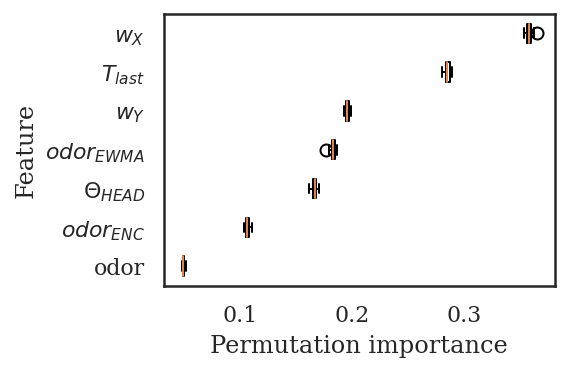

In [24]:
sorted_idx = result.importances_mean.argsort()
print(sorted_idx)
x_labels = [
#     'wind_theta_obs', 
    r'$w_{X}$', 
    r'$w_{Y}$', 
    'odor',
    r'$T_{last}$',
    r'$\Theta_{HEAD}$',
#     r'$odor_{MA}$',
    r'$odor_{EWMA}$',
    r'$odor_{ENC}$',
]

fig, ax = plt.subplots(figsize=(3.5,2.5))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, 
#            labels=X_train.columns[sorted_idx],
           labels=[x_labels[i] for i in sorted_idx],
          )
# ax.set_title("Permutation Importances (train set)")
# ax.set_title("Permutation importances")
plt.ylabel("Feature")
plt.xlabel("Permutation importance")
# fig.tight_layout()
# plt.show()

fname = f"{outdir}/repr_{model_seed}.png"
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
print("Saved:", fname)


Text(0.5, 0, 'Permutation importance')

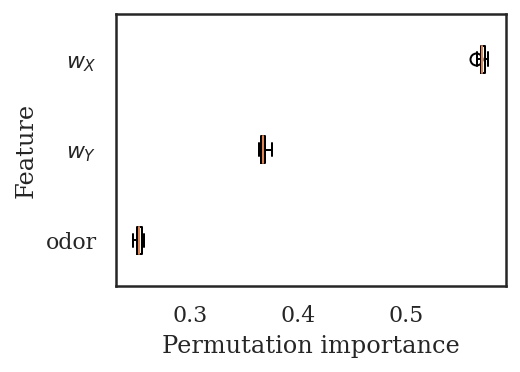

In [25]:
baseline_x_labels = [
    r'$w_{X}$', 
    r'$w_{Y}$', 
    'odor',
]
baseline_result = permutation_importance(baseline_clf, 
                                X_train_baseline,
                                y_train, 
                                n_repeats=30,
                                random_state=42, 
                                n_jobs=20)
baseline_sorted_idx = baseline_result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(3.5,2.5))
ax.boxplot(baseline_result.importances[baseline_sorted_idx].T,
           vert=False, 
           labels=[baseline_x_labels[i] for i in baseline_sorted_idx],
          )
plt.ylabel("Feature")
plt.xlabel("Permutation importance")
# fname = f"{outdir}/repr_baseline_{model_seed}.png"
# plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
# print("Saved:", fname)

## Can we identify a subset of neurons that encode head direction and say anything about their connectivity?



In [26]:
h_episodes_stacked.shape, traj_df_stacked.shape
traj_df_stacked.head()

# Continuous + Regress
# X_train = traj_df_train.loc[:, 'h'].fillna(0)
# X_test = traj_df_test.loc[:, 'h'].fillna(0)
# y_train = traj_df_train['agent_angle_ground'].fillna(0)
# y_test = traj_df_test['agent_angle_ground'].fillna(0)

# X_train = np.array(X_train.to_list())
# X_test = np.array(X_test.to_list())

# from sklearn.ensemble import RandomForestRegressor
# clf = RandomForestRegressor(n_estimators=20, n_jobs=20)
# clf.fit(X_train, y_train)

# Discretize and classify
X_train = traj_df_train.loc[:, 'h'].fillna(0)
X_test = traj_df_test.loc[:, 'h'].fillna(0)
y_train = traj_df_train['head_discrete'].fillna(0)
y_test = traj_df_test['head_discrete'].fillna(0)

X_train = np.array(X_train.to_list())
X_test = np.array(X_test.to_list())

from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators=30, n_jobs=20)
clf3.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, n_jobs=20)

In [27]:
clf3.score(X_test, y_test)

0.8179301533219762

In [28]:
result = permutation_importance(clf3, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=20)
sorted_idx = result.importances_mean.argsort()

In [29]:
sorted_idx

array([23, 27, 56,  1,  4, 55,  6, 29, 44, 47, 20, 49, 46,  2, 10, 30, 35,
       62, 48, 24, 45, 12, 59, 28, 61, 63, 18, 53, 36, 39,  9, 38,  7, 57,
       50, 34, 11, 15,  3, 41, 51, 21,  8, 19,  5, 52, 25, 17, 54, 32, 43,
       26, 16, 22, 58,  0, 42, 37, 13, 33, 14, 31, 60, 40])

Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//ring_imps_2760377.png


(64, 10)

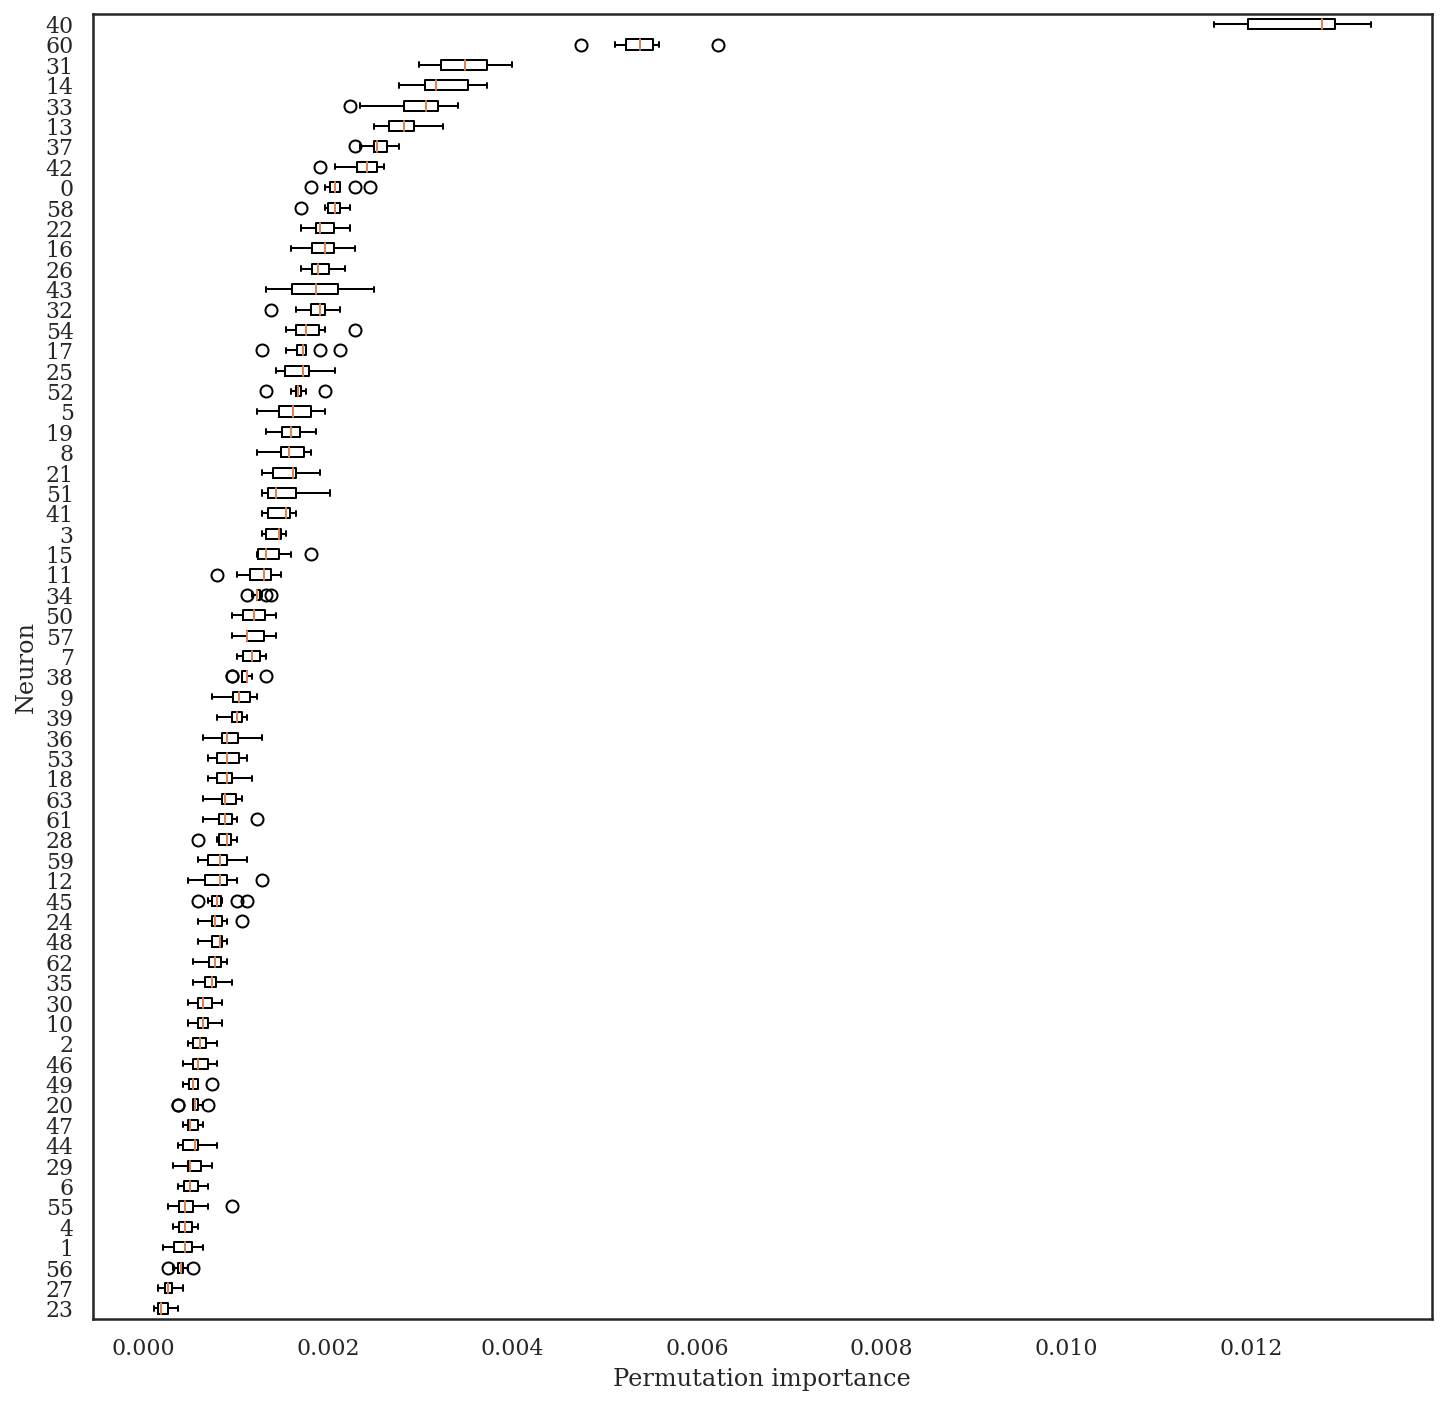

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, 
           labels=sorted_idx,
#            labels=[x_labels[i] for i in sorted_idx],
          )
# ax.set_title("Permutation Importances (train set)")
# ax.set_title("Permutation importances")
plt.ylabel("Neuron")
plt.xlabel("Permutation importance")

fname = f"{outdir}/ring_imps_{model_seed}.png"
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
print("Saved:", fname)



result.importances[sorted_idx].shape

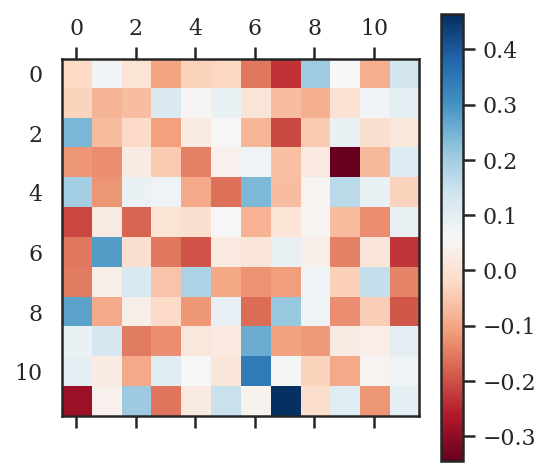

In [31]:
model_fname = model_dir[:-1] + ".pt"
actor_critic, ob_rms = \
        torch.load(model_fname, map_location=torch.device('cpu'))
net = actor_critic.base.rnn #.weight_hh_l0.detach().numpy()
J0 = net.weight_hh_l0.detach().numpy()
# archu.plot_eig(J0)    

n_subset = 12 # look at top 12 most imp. neurons
idxs_subset = sorted_idx[:n_subset]
# J0[idxs_subset, idxs_subset]
J0.shape
idxs_subset

J_subset = J0[idxs_subset,:][:,idxs_subset]
plt.matshow(J_subset, cmap='RdBu')
plt.colorbar()



In [32]:
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

# n_clusters = 3
# for n_clusters in np.arange(2, n_subset+1):
#     model = SpectralBiclustering(n_clusters=n_clusters, 
#                                  method='log',
#                                  random_state=0)

#     model.fit(J_subset)
#     fit_data = J_subset[np.argsort(model.row_labels_)]
#     fit_data = fit_data[:, np.argsort(model.column_labels_)]

#     plt.matshow(fit_data, cmap='RdBu')
#     plt.colorbar()
#     plt.title(n_clusters)
#     plt.show()
#     score = consensus_score(model.biclusters_,
#                             (J_subset, J_subset))
#     print("consensus score: {:.1f}".format(score))

#     fname = f"{outdir}/ring_bicluster_{n_clusters}_{model_seed}.png"
#     plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
#     print("Saved:", fname)



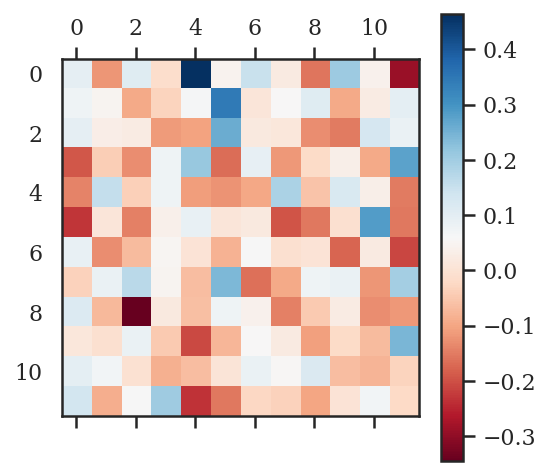

In [33]:
# https://en.wikipedia.org/wiki/Cuthill–McKee_algorithm
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.reverse_cuthill_mckee.html
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

csr = csr_matrix(J_subset)
ordering = reverse_cuthill_mckee(csr)

J_ordered = J_subset[ordering,:][:,ordering]
plt.matshow(J_ordered, cmap='RdBu')
plt.colorbar()


Saved: /home/satsingh/plume/plumezoo/latest/fly/memory/plume_20210601_VRNN_constantx5b5noisy3x5b5_stepoob_bx0.30.8_t10000004000000_q2.00.5_dmx0.80.8_dmn0.70.4_h64_wd0.0001_n4_codeVRNN_seed2760377//report_arch//ring_hungarian_2760377.png


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 8,  3,  9, 11,  2,  5,  1,  4,  0, 10,  6,  7]))

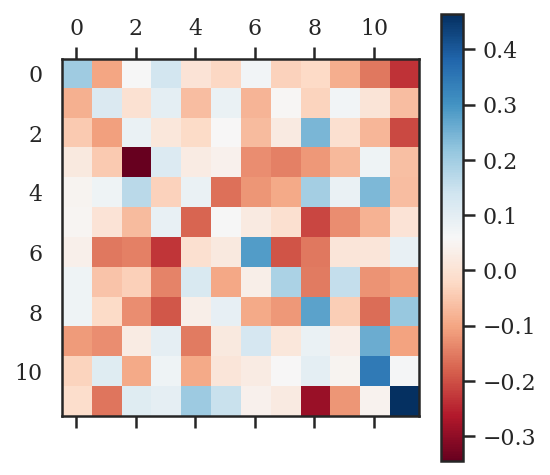

In [34]:
# https://math.stackexchange.com/questions/2874737/rearranging-columns-of-an-almost-diagonal-matrix
# Hungarian algo
from scipy.optimize import linear_sum_assignment
cost = -J_subset
row_ind, col_ind = linear_sum_assignment(cost)
J_ordered = J_subset[row_ind,:][:,col_ind]
plt.matshow(J_ordered, cmap='RdBu')
plt.colorbar()

fname = f"{outdir}/ring_hungarian_{model_seed}.png"
plt.savefig(fname, dpi=dpi_save, bbox_inches='tight')
print("Saved:", fname)

row_ind, col_ind

<AxesSubplot:>

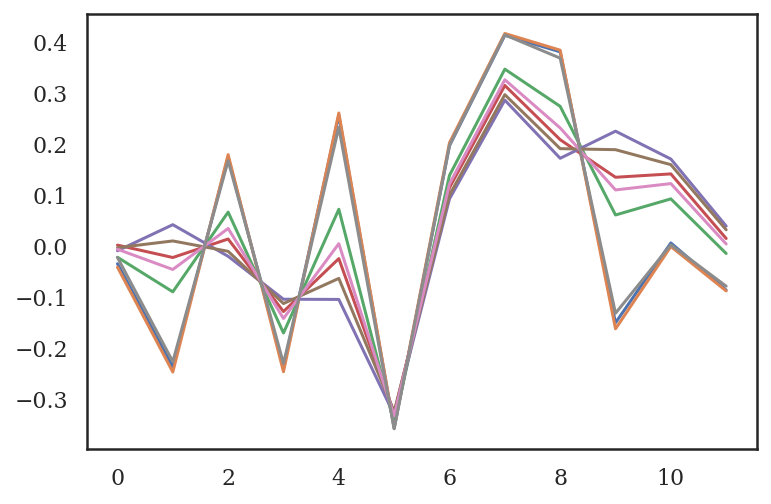

In [35]:
# Neural activity associated with each bin

X_t = pd.DataFrame(X_train[:, idxs_subset][:,col_ind]) # 
X_t['head_dir'] = y_train
X_t.head()

X_t.groupby(by='head_dir').mean().T.plot(legend=None)

In [36]:
# import sklearn.decomposition as skld
# ep_act = X_t.to_numpy()[:,:-1]
# n_comp = 3
# pca_common = skld.PCA(n_comp, whiten=False)
# pca_common.fit(ep_act)
# X_pca = pca_common.transform(ep_act)

# fig = plt.figure(figsize=(5,5))
# ax = fig.gca(projection='3d')
# sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
#             s=10, 
#             c=y_train, 
#             cmap='twilight', 
#             alpha=0.5)

# plt.colorbar(sc)